In [1]:
import numpy as np
import pandas as pd
import quantstats as qs

from datetime import date
from typing import Callable

import matplotlib.pyplot as plt

## Open database

In [2]:
patterns = {
    'close': 'Fechamento\r\najust p/ prov\r\nEm moeda orig\r\n',
    'negotiable': 'Negociabilidade\n1 meses\nEm moeda orig\n'
}

def clean_dataframe(df, pattern):
    df.columns = df.columns.str.replace(pattern, '')

    dates = pd.to_datetime(df['Data'], dayfirst=True)

    # Detach dates
    tickers = [col for col in df.columns if col != 'Data']
    df = df[tickers]

    # comma_to_dot = lambda x: x.replace('.', '').replace(',', '.')
    # df = df.applymap(comma_to_dot)
    df = df.replace('-', np.nan)
    df = df.apply(pd.to_numeric)

    # Reattach dates
    df['Data'] = dates
    
    # Reorder columns so that dates show up first
    cols = ['Data'] + list(df.columns.drop('Data'))
    df = df[cols]
    
    # Drop weekends and holidays
    df = df.dropna(axis=0, how='all', subset=tickers)
    
    return df

In [3]:
path = './../data/close.csv'
close = pd.read_csv(path, delimiter=',')
close = clean_dataframe(close, patterns['close'])

close.tail(2)

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
9613,2022-11-08,47.00,12.13,NaN,NaN,NaN,NaN,NaN,21.50,NaN,...,NaN,NaN,NaN,NaN,13.98,NaN,NaN,NaN,7.1,NaN
9614,2022-11-09,46.21,12.00,NaN,NaN,NaN,NaN,NaN,21.09,NaN,...,NaN,NaN,NaN,NaN,13.72,NaN,NaN,NaN,7.3,NaN


In [4]:
path = './../data/in.csv'
negotiable = pd.read_csv(path, delimiter=',')
negotiable = clean_dataframe(negotiable, patterns['negotiable'])

negotiable.tail(2)

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
9613,2022-11-08,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.11,NaN,...,NaN,NaN,NaN,NaN,0.47,NaN,NaN,NaN,0.06,NaN
9614,2022-11-09,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.10,NaN,...,NaN,NaN,NaN,NaN,0.46,NaN,NaN,NaN,0.06,NaN


In [5]:
def get_IBRX_assets(today_date):
    s = negotiable.set_index('Data').loc[:today_date].iloc[-1]
    s = s.sort_values(ascending=False)
    return s.index[:100]

## Defining utility functions

In [6]:
def how_many_days_since_last_trading_day(today_date, df):
    """
    :param date today_date:
    :param pd.DataFrame df: DataFrame with a datetime index
    """
    quotes_until_now = df.loc[:today_date, :].reset_index(names='index')
    
    last_day = quotes_until_now.iloc[-1]['index']
    if last_day.date() == today_date:
        last_day = quotes_until_now.iloc[-2]['index']
    
    return today_date - last_day.date()


def trading_day_immediately_before(today_date, df):        
    return today_date - how_many_days_since_last_trading_day(today_date, df)

def run_backtest(
    close: pd.DataFrame, 
    start_date: date, 
    end_date: date, 
    rebalance: int,
    get_tickers: Callable,
    args: list
    ):
    """
    :param pd.DataFrame close: DataFrame of closing prices with a datetime index
    :param date start_date:
    :param date end_date:
    :param date rebalance: rebalancing time delta in months
    """
    portfolio = pd.DataFrame()
    
    today = pd.Timestamp(start_date)
    while today.date() <= end_date:
        next_date = today + pd.DateOffset(months=rebalance)
        
        # Asset selection
        tickers = get_tickers(close, today, *args)
        
        # Once we have our tickers, we assemble our quotes
        first_quote = trading_day_immediately_before(today.date(), close)
        last_quote  = trading_day_immediately_before(next_date.date(), close)
        
        iteration_returns = close.loc[first_quote:last_quote, tickers].pct_change().mean(axis=1)
        iteration_returns = iteration_returns.to_frame(name='pctChange')
        iteration_returns = iteration_returns.iloc[1:].loc[:end_date]
        
        portfolio = pd.concat([portfolio, iteration_returns])
        
        today = next_date
        
    return portfolio

## Testing a momentum/low-vol strategy

In [7]:
def rank_stocks_by_momentum(df, today_date, lookback, position_column='pos-momentum'):
    start_of_analysis = today_date - pd.DateOffset(months=lookback)
    returns = df.loc[start_of_analysis:today_date, :].pct_change().add(1).cumprod().iloc[-1]
    
    returns = returns.to_frame(name='return').dropna()
    returns = returns.sort_values(by='return', ascending=False)
    returns[position_column] = range(0, len(returns))
    
    return returns

def rank_stocks_by_volatility(df, today_date, lookback, position_column='pos-low-volatility'):
    start_of_analysis = today_date - pd.DateOffset(months=lookback)
    
    daily_movement = df.loc[start_of_analysis:today_date, :].pct_change()
    
    volatility = daily_movement.std().to_frame(name='std')
    volatility['periods'] = daily_movement.count()
    volatility['volatility'] = volatility['std'] * volatility['periods'] ** (1 / 2)
    volatility = volatility.sort_values(by='volatility')
    volatility[position_column] = range(0, len(volatility))
    
    return volatility

In [8]:
momentum = rank_stocks_by_momentum(close.set_index('Data').loc[:, get_IBRX_assets(date(2022, 1, 1))], date(2022, 1, 1), 12)
momentum.head(2)

,return,pos-momentum
ASAI3,4.436657,0
EMBR3,2.965352,1


In [9]:
vol = rank_stocks_by_volatility(close.set_index('Data').loc[:, get_IBRX_assets(date(2022, 1, 1))], date(2022, 1, 1), 12)
vol.head(2)

,std,periods,volatility,pos-low-volatility
ENBR3,0.012995,246,0.203815,0
VIVT3,0.013676,246,0.214498,1


In [10]:
def assemble_intersectional_model(ranks, position_columns):
    ranking = pd.concat(ranks, axis=1).loc[:, position_columns]
    ranking['pos'] = sum([ranking[pcol] for pcol in position_columns])
    return ranking.sort_values(by='pos')
    
ranked_assets = assemble_intersectional_model([momentum, vol], ['pos-momentum', 'pos-low-volatility'])
ranked_assets.head(2)

,pos-momentum,pos-low-volatility,pos
TAEE11,10,2,12
VIVT3,19,1,20


In [11]:
def get_tickers(df, today_date, assets=5):
    df = df.loc[:, get_IBRX_assets(today_date)]
    
    momentum = rank_stocks_by_momentum(df, today_date, 12)
    vol = rank_stocks_by_volatility(df, today_date, 12)
    
    ranked_assets = assemble_intersectional_model([momentum, vol], ['pos-momentum', 'pos-low-volatility'])
    return ranked_assets.index[:assets]

get_tickers(close.set_index('Data'), date(2022, 1, 1))

Index(['TAEE11', 'VIVT3', 'ENBR3', 'JBSS3', 'CMIG4'], dtype='object')

In [12]:
p = run_backtest(close.set_index('Data'), date(2015, 1, 1), date(2020, 1, 1), 1, get_tickers, [])

In [14]:
qs.stats.cagr(p['pctChange'])

0.37717329839112557

Include benchmark index.

In [15]:
benchmark = pd.read_csv('./../data/benchmark.csv')
benchmark['Date'] = pd.to_datetime(benchmark['Date'])
benchmark = benchmark.set_index('Date')

## Parameter analysis for the momentum factor

In [16]:
def get_tickers(df, today_date, momentum_lookback, assets):
    df = df.loc[:, get_IBRX_assets(today_date)]
    
    momentum = rank_stocks_by_momentum(df, today_date, momentum_lookback)
    # vol = rank_stocks_by_volatility(df, today_date, 12)
    
    ranked_assets = assemble_intersectional_model([momentum], ['pos-momentum'])
    return ranked_assets.index[:assets]

start_date = date(2010, 1, 1)
end_date = date(2020, 1, 1)

results_momentum = []

for lookback in np.arange(1, 12 + 1, 1):
    for asset_count in np.arange(5, 30 + 5, 5):
        # print(f"Backtesting with {lookback} months momentum lookback and {asset_count} assets...")
        p = run_backtest(close.set_index('Data'), start_date, end_date, 1, get_tickers, [lookback, asset_count])
        
        results_momentum.append({
            'lookback': lookback,
            'assets': asset_count,
            'cagr': qs.stats.cagr(p['pctChange']),
            'vol': qs.stats.volatility(p['pctChange'])
        })

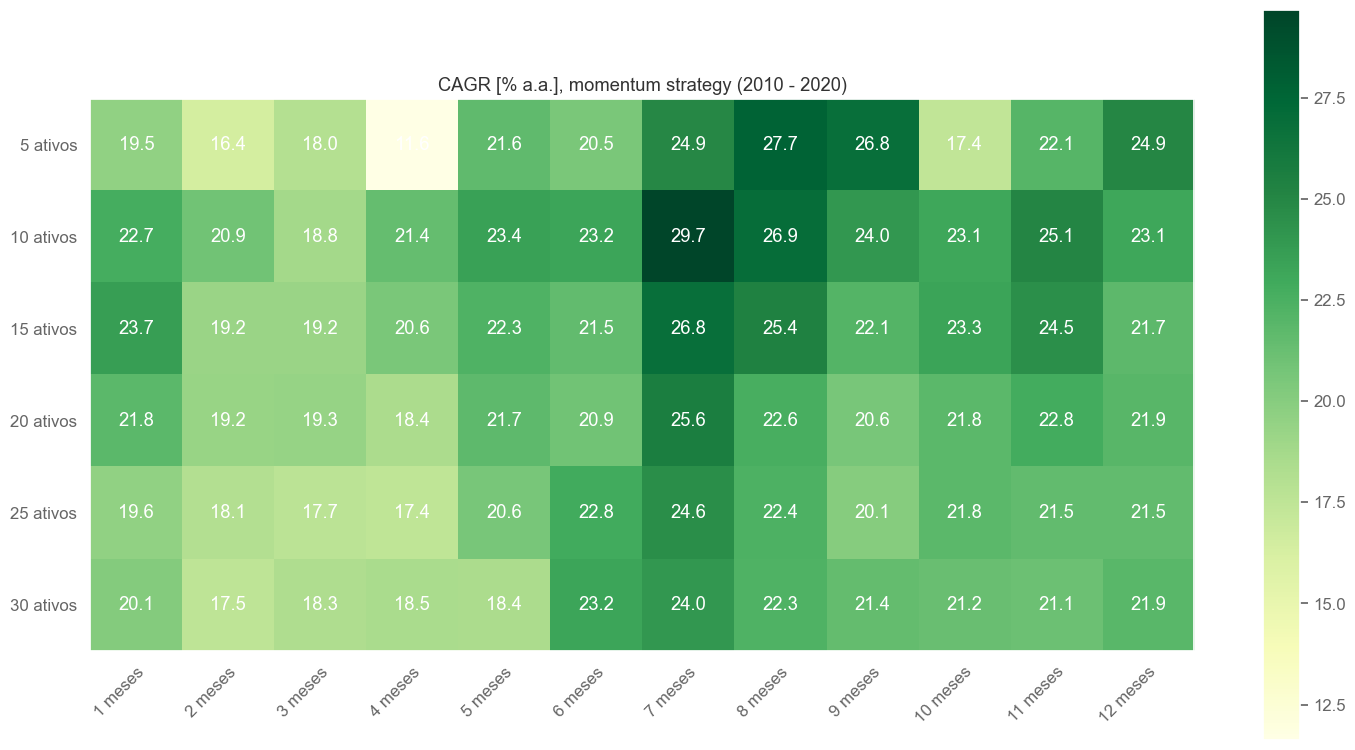

In [17]:
cagr = pd.DataFrame(results_momentum).pivot(index='assets', columns='lookback', values='cagr')
cagr *= 100

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cagr, cmap="YlGn")
ax.grid(False)

cbar = ax.figure.colorbar(im, ax = ax, shrink=0.5)

lookback = cagr.columns.values
assets = cagr.index.values

# Add axis tick labels
ax.set_xticks(np.arange(len(lookback)), labels=[f'{m} meses' for m in lookback])
ax.set_yticks(np.arange(len(assets)),labels=[f'{m} ativos' for m in assets])

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

# Create text annotations
for i in range(len(assets)):
    for j in range(len(lookback)):
        text = ax.text(j, i, round(cagr.iloc[i, j], 1),
                       ha="center", va="center", color="w")

ax.set_title("CAGR [% a.a.], momentum strategy (2010 - 2020)")
fig.tight_layout()

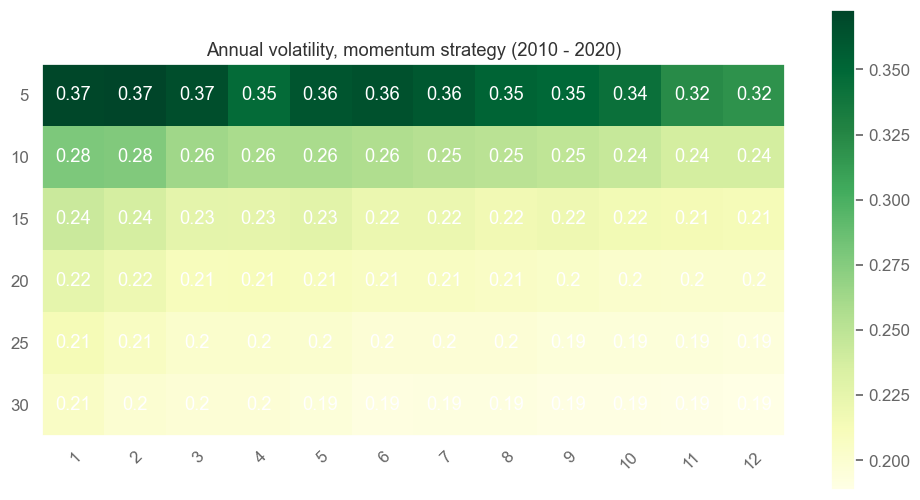

In [18]:
vol = pd.DataFrame(results_momentum).pivot(index='assets', columns='lookback', values='vol')

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(vol, cmap="YlGn")
ax.grid(False)

cbar = ax.figure.colorbar(im, ax = ax, shrink=0.5)

lookback = vol.columns.values
assets = vol.index.values

# Add axis tick labels
ax.set_xticks(np.arange(len(lookback)), labels=lookback)
ax.set_yticks(np.arange(len(assets)),labels=assets)

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

# Create text annotations
for i in range(len(assets)):
    for j in range(len(lookback)):
        text = ax.text(j, i, round(vol.iloc[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Annual volatility, momentum strategy (2010 - 2020)")
fig.tight_layout()

## Parameter analysis for the low volatility factor

In [19]:
def get_tickers(df, today_date, low_vol_lookback, assets):
    df = df.loc[:, get_IBRX_assets(today_date)]
    
    # momentum = rank_stocks_by_momentum(df, today_date, momentum_lookback)
    vol = rank_stocks_by_volatility(df, today_date, low_vol_lookback)
    
    ranked_assets = assemble_intersectional_model([vol], ['pos-low-volatility'])
    return ranked_assets.index[:assets]

start_date = date(2010, 1, 1)
end_date = date(2020, 1, 1)

results_low_vol = []

for lookback in np.arange(4, 24 + 1, 2):
    for asset_count in np.arange(5, 30 + 5, 5):
        # print(f"Backtesting with {lookback} months momentum lookback and {asset_count} assets...")
        p = run_backtest(close.set_index('Data'), start_date, end_date, 1, get_tickers, [lookback, asset_count])
        
        results_low_vol.append({
            'lookback': lookback,
            'assets': asset_count,
            'cagr': qs.stats.cagr(p['pctChange']),
            'vol': qs.stats.volatility(p['pctChange'])
        })

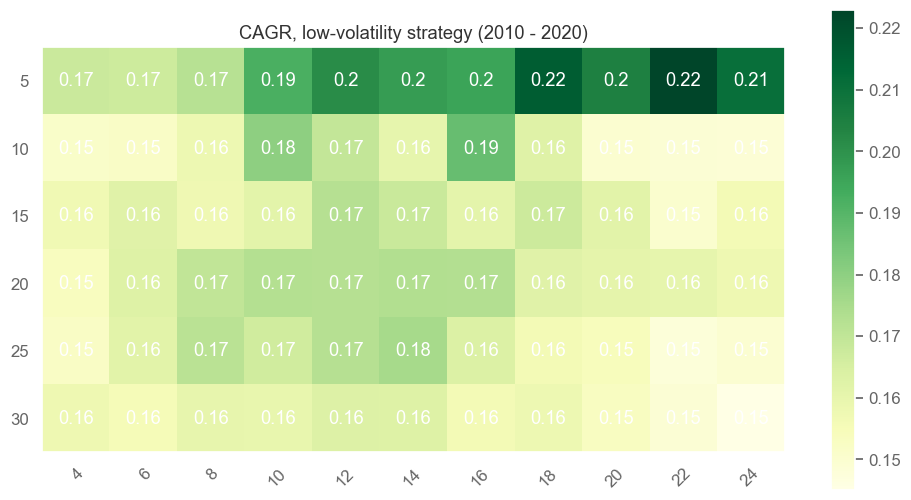

In [20]:
cagr = pd.DataFrame(results_low_vol).pivot(index='assets', columns='lookback', values='cagr')

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cagr, cmap="YlGn")
ax.grid(False)

cbar = ax.figure.colorbar(im, ax = ax, shrink=0.5)

lookback = cagr.columns.values
assets = cagr.index.values

# Add axis tick labels
ax.set_xticks(np.arange(len(lookback)), labels=lookback)
ax.set_yticks(np.arange(len(assets)),labels=assets)

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

# Create text annotations
for i in range(len(assets)):
    for j in range(len(lookback)):
        text = ax.text(j, i, round(cagr.iloc[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("CAGR, low-volatility strategy (2010 - 2020)")
fig.tight_layout()

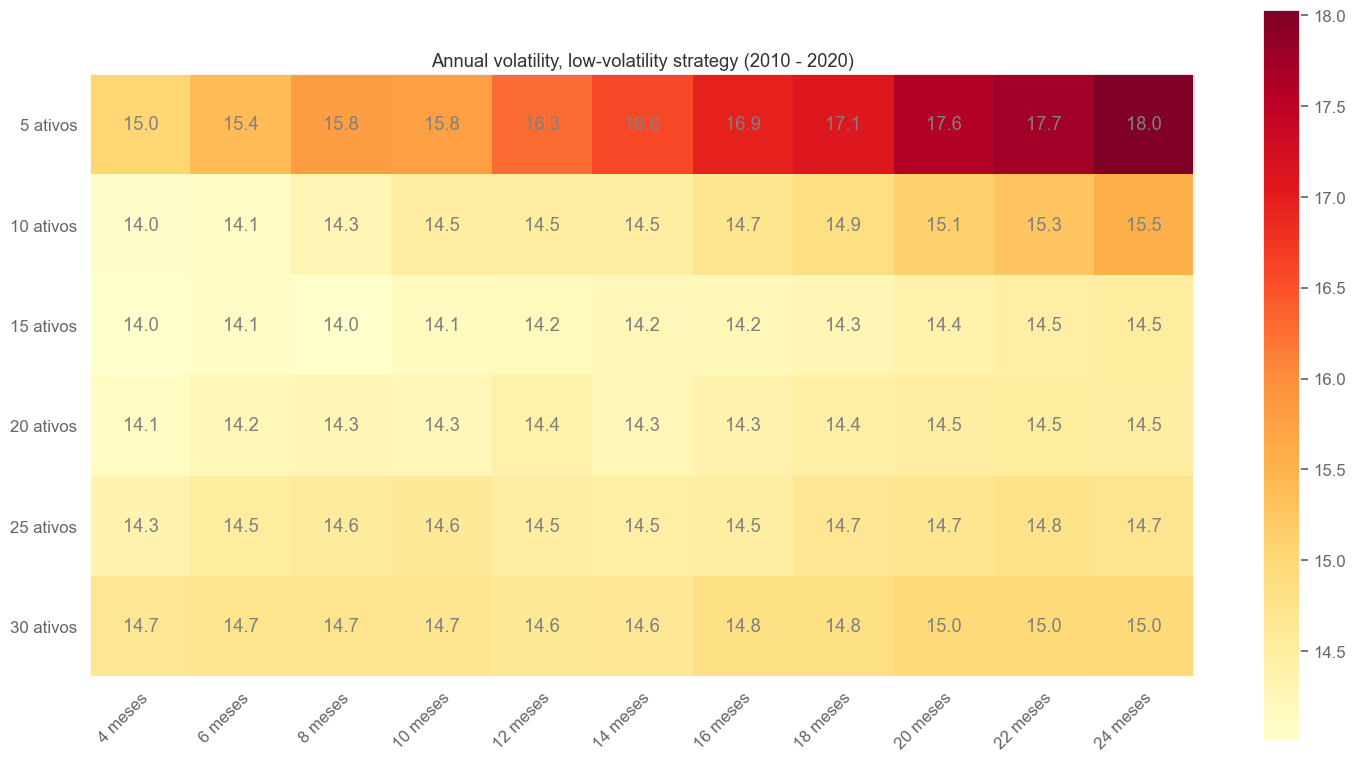

In [21]:
vol = pd.DataFrame(results_low_vol).pivot(index='assets', columns='lookback', values='vol')
vol *= 100

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(vol, cmap="YlOrRd")
ax.grid(False)

cbar = ax.figure.colorbar(im, ax = ax, shrink=0.5)

lookback = vol.columns.values
assets = vol.index.values

# Add axis tick labels
ax.set_xticks(np.arange(len(lookback)), labels=[f'{m} meses' for m in lookback])
ax.set_yticks(np.arange(len(assets)),labels=[f'{m} ativos' for m in assets])

plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

# Create text annotations
for i in range(len(assets)):
    for j in range(len(lookback)):
        text = ax.text(j, i, round(vol.iloc[i, j], 1),
                       ha="center", va="center", color="gray")

ax.set_title("Annual volatility, low-volatility strategy (2010 - 2020)")
fig.tight_layout()

## Testing a portfolio with optimized parameters

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-03-01  2010-03-01
End Period                 2021-12-30  2021-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      82.0%

Cumulative Return          977.1%      107.89%
CAGR﹪                     22.23%      6.38%

Sharpe                     1.21        0.38
Prob. Sharpe Ratio         99.99%      89.99%
Smart Sharpe               1.09        0.34
Sortino                    1.65        0.53
Smart Sortino              1.49        0.48
Sortino/√2                 1.17        0.38
Smart Sortino/√2           1.05        0.34
Omega                      1.24        1.24

Max Drawdown               -37.5%      -47.56%
Longest DD Days            364         1349
Volatility (ann.)          18.38%      24.92%
R^2                        0.43        0.43
Information Ratio          0.04        0.04
Calmar                     0.59       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-18,2020-11-23,277,-37.495184,-34.414258
2,2015-07-16,2016-01-20,2016-07-14,364,-21.390395,-20.677080
3,2021-01-15,2021-12-01,2021-12-30,349,-18.790182,-17.887752
4,2014-09-04,2014-10-23,2015-02-25,174,-14.030852,-13.569199
5,2018-04-19,2018-06-18,2018-12-28,253,-13.301972,-12.774598


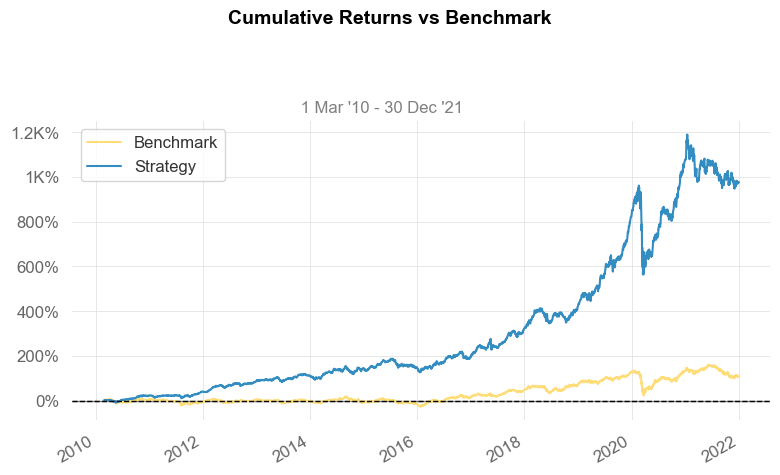

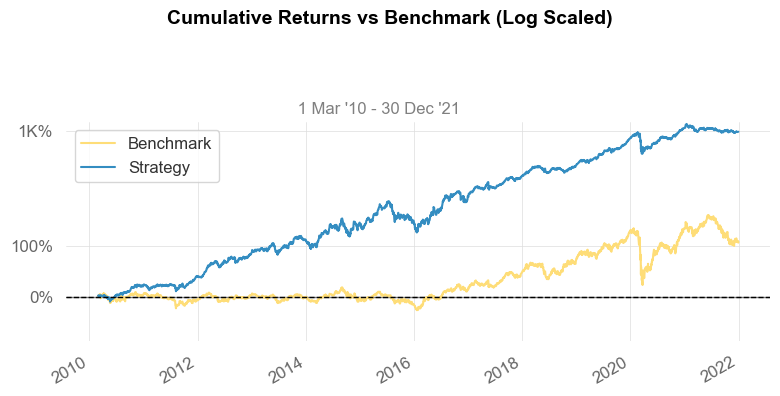

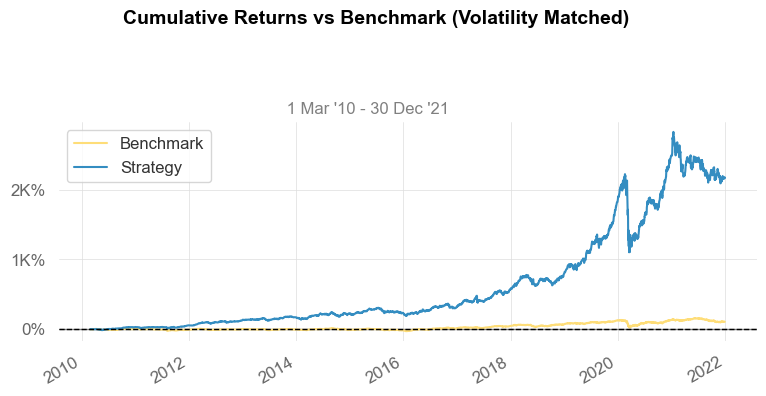

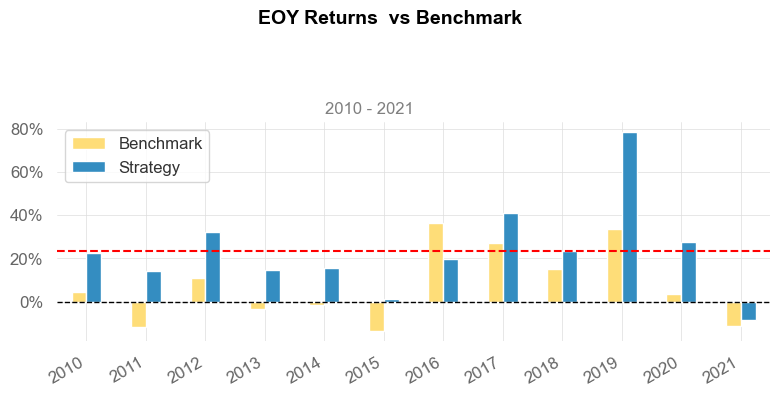

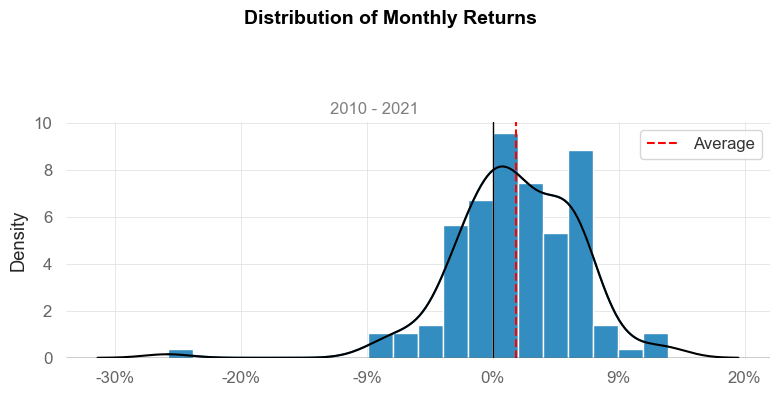

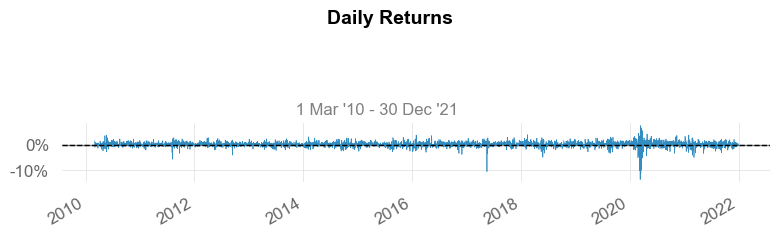

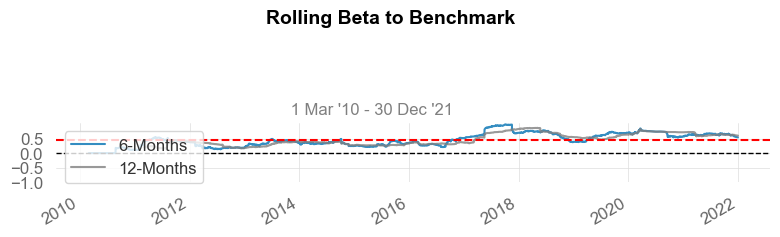

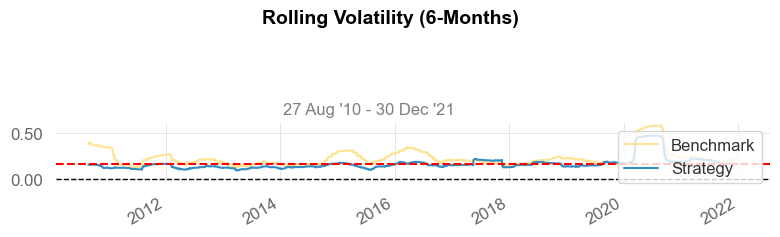

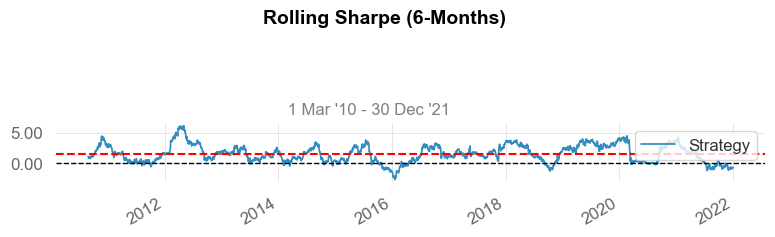

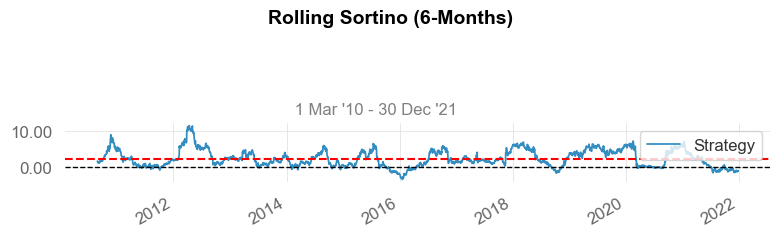

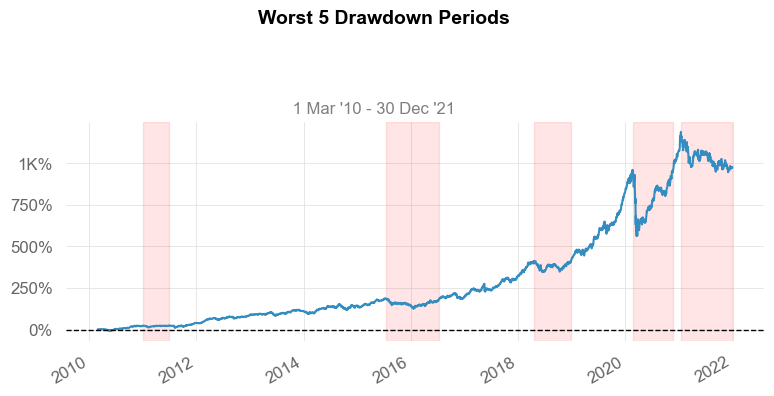

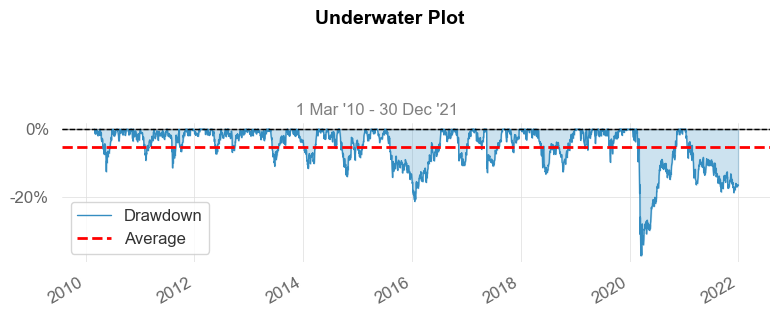

/Users/pedro/Developer/quant-modeling/venv/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


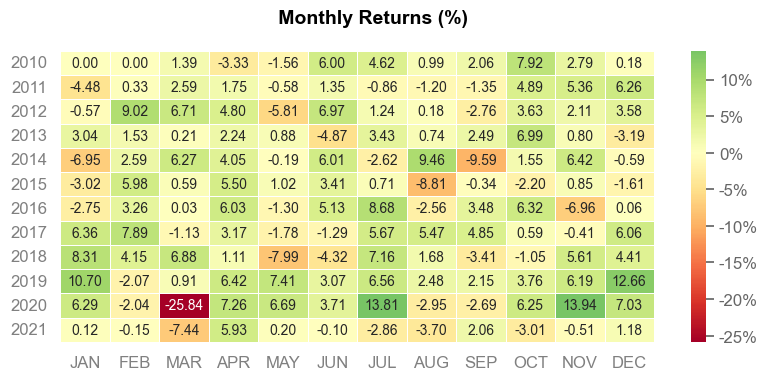

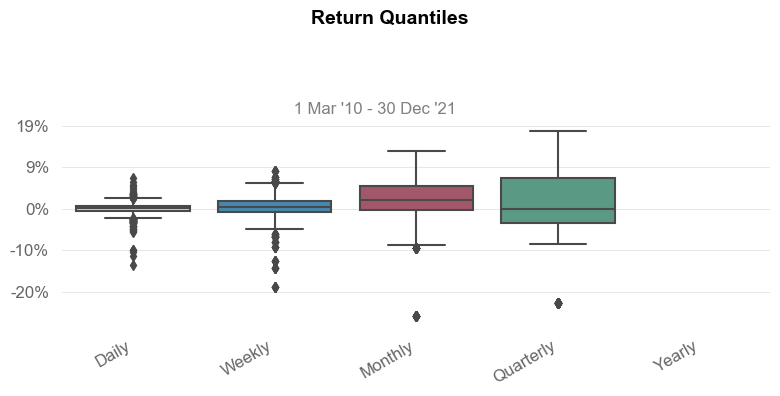

In [22]:
def get_tickers(df, today_date, assets=10):
    df = df.loc[:, get_IBRX_assets(today_date)]
    
    momentum = rank_stocks_by_momentum(df, today_date, 8)
    vol = rank_stocks_by_volatility(df, today_date, 12)
    
    ranked_assets = assemble_intersectional_model([momentum, vol], ['pos-momentum', 'pos-low-volatility'])
    return ranked_assets.index[:assets]

p = run_backtest(close.set_index('Data'), date(2010, 3, 1), date(2022, 1, 1), 1, get_tickers, [])

qs.reports.full(p['pctChange'], benchmark)